In [43]:
!pip3 install -q --upgrade ipython keras scikit-learn
!pip3 install -q --upgrade ipykernel Pillow seaborn pandas matplotlib opencv-python
!ls -la chest_Xray

total 36
drwxr-xr-x 5 mathou mathou  4096 mars  16 14:37 .
drwxr-xr-x 6 mathou mathou  4096 mai    4 14:07 ..
-rw-r--r-- 1 mathou mathou 12292 mars  16 14:37 .DS_Store
drwxr-xr-x 4 mathou mathou  4096 mars  16 14:37 test
drwxr-xr-x 4 mathou mathou  4096 mars  16 14:37 train
drwxr-xr-x 4 mathou mathou  4096 mars  16 14:37 val


In [44]:
import os
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from PIL import Image
from sklearn.ensemble import ExtraTreesClassifier
import cv2
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [45]:
TEST_PATH = "./chest_Xray/test"
TRAIN_PATH = "./chest_Xray/train"
VAL_PATH = "./chest_Xray/val"

# Creation of Train, Val and Test datasets

In [46]:
def create_dataset(PATH):
    X = []
    Y = []
    for elem in os.listdir(PATH):
        is_pneumonia = 0.
        if elem == "PNEUMONIA":
            is_pneumonia = 1.
        try:
            for filename in os.listdir(PATH + "/" + elem):
                try:
                    path = PATH + "/" + elem + "/"
                    img = cv2.imread(str(path+filename))
                    img = cv2.resize(img, (224,224))
                    img = img.astype(np.float32)/255.
                    X.append(img)
                    Y.append(is_pneumonia)
                except:
                    print(filename + " failed")
                    pass
        except:
            pass
    X = np.array(X).reshape(-1, 224*224*3)
    Y = np.array(Y)
    return X, Y

.DS_Store failed
.DS_Store failed


In [48]:
train_X, train_Y = create_dataset(TRAIN_PATH)
val_X, val_Y = create_dataset(VAL_PATH)
test_X, test_Y = create_dataset(TEST_PATH)

# Data exploration

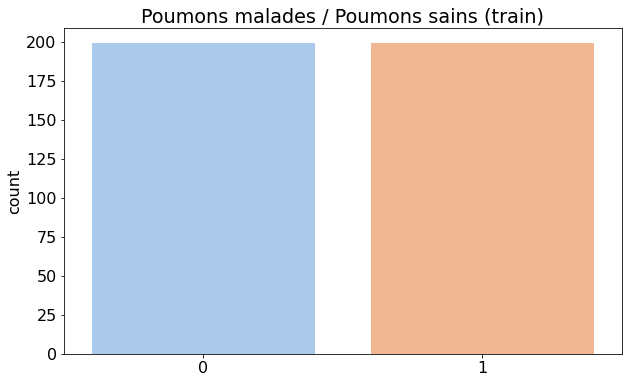

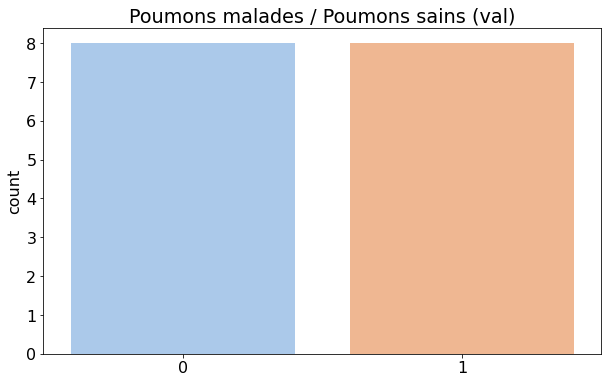

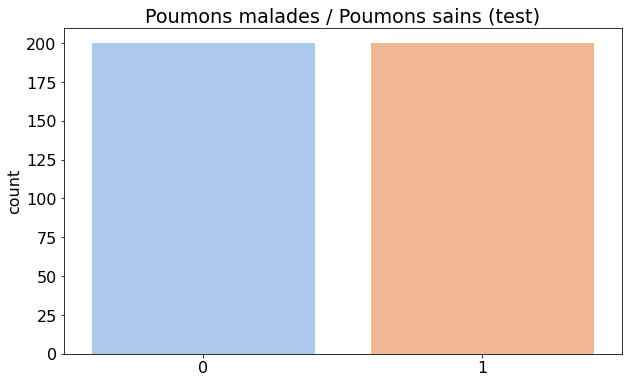

In [49]:
# PLOT POUMONS
labels = ["Normal", "Pneumonia"]

plt.figure(figsize=(10,6))
plt.title("Poumons malades / Poumons sains (train)")
sns.countplot(train_Y.astype(int), palette=sns.color_palette("pastel"))

plt.figure(figsize=(10,6))
plt.title("Poumons malades / Poumons sains (val)")
sns.countplot(val_Y.astype(int), palette=sns.color_palette("pastel"))

plt.figure(figsize=(10,6))
plt.title("Poumons malades / Poumons sains (test)")
sns.countplot(test_Y.astype(int), palette=sns.color_palette("pastel"))

# Creation and training step of the model

In [50]:
model = ExtraTreesClassifier(random_state = 20, n_estimators = 150, max_depth = 10, 
                               max_features = 2)
model.fit(train_X, train_Y)
scores = cross_val_score(model, val_X, val_Y)
print(str(scores.mean()) + " / " + str(scores.std()))

0.6333333333333333 / 0.22110831935702666


# Validation step

In [51]:
scores_preds = cross_val_predict(model, test_X, test_Y)
scores_probas = model.predict_proba(test_X)[:, 1]
print(str(scores_preds.mean()) + " / " + str(scores_preds.std()))

0.49 / 0.4998999899979995


# Test step : Final model accuracy

In [52]:
accuracy = roc_auc_score(test_Y, scores_preds)
print(accuracy)

0.9000000000000001


# Predictions and model metrics plots

Text(0.5, 1.0, 'ROC Curves')

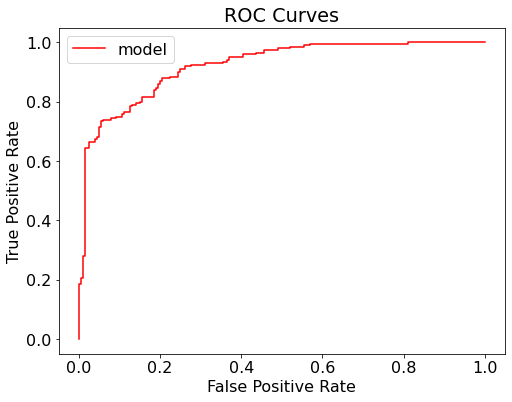

In [53]:
false_positive, true_positive, _ = roc_curve(test_Y, scores_probas)
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(false_positive, true_positive, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')

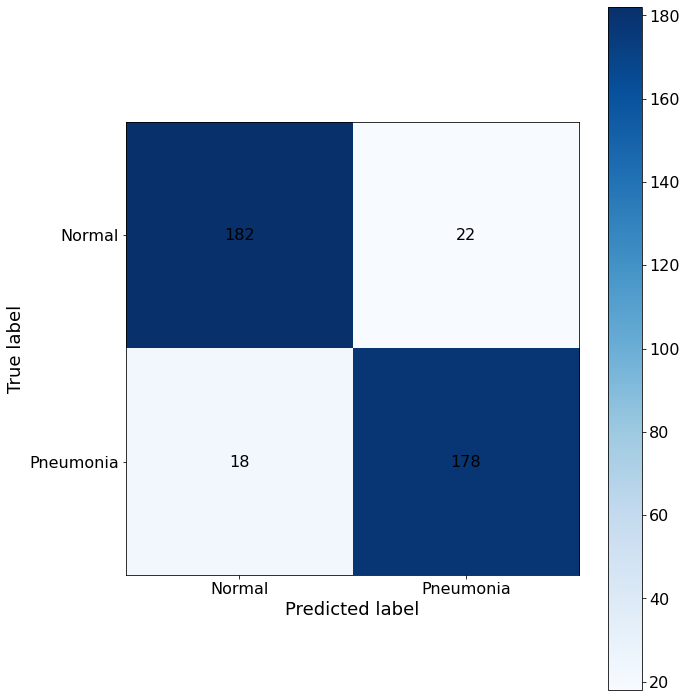

In [54]:
cm = confusion_matrix(test_Y, scores_preds)
classes = ['Normal', 'Pneumonia']
title = 'predictions HeatMap'
plt.figure(figsize = (10, 10))

plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
for i in range(0, len(classes)):
    for j in range(0, len(classes)):
        text = plt.text(i, j, cm[i, j], ha="center", va="center")
plt.ylabel('True label', size = 18)
plt.xlabel('Predicted label', size = 18)
plt.tight_layout()
plt.show()

## Predictions distribution

{'whiskers': [<matplotlib.lines.Line2D at 0x7f94e27c6bd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f94e27d1f90>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7f94e27c6b50>,
 'medians': [<matplotlib.lines.Line2D at 0x7f94e287e3d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f94e2783d50>,
 'means': []}

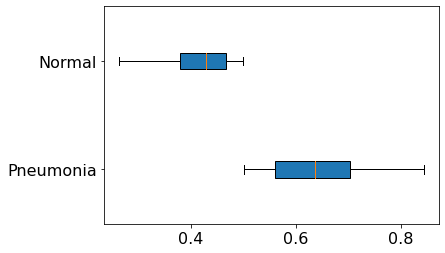

In [55]:
pneumonia = scores_probas[scores_probas.round()==True]
normal = scores_probas[scores_probas.round()==False]

green_diamond = dict(markerfacecolor='g', marker='D')

plt.boxplot([pneumonia, normal], labels=['Pneumonia', 'Normal'],
            flierprops=green_diamond, vert=False, patch_artist=True)